In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np #linear algebra
import seaborn as sns #data visualization

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import plotly.graph_objects as go
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/lastriita/DataVisualization2022/main/Bank%20Customer%20Churn%20Prediction.csv")

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
del df["customer_id"]
df.isna().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [5]:
level_count = df["churn"].value_counts()
data = [
    go.Pie(
        labels=["Never Left the Bank","Has Left the Bank at Some Point"],
        values=level_count,
        textinfo='percent',
        insidetextorientation='radial', 
        marker_colors = ["lightblue", "mediumseagreen"],
        rotation = -55,
    )
]

layout = go.Layout(title = "Representación del Churn del Banco")

fig = go.Figure(data = data, layout = layout)

fig.show()

In [6]:
data = [
    go.Box(
        
        y = df["balance"].loc[df["churn"]==0],
        marker_color = "firebrick",
        name = "Clients that Never Left the Bank",
        boxmean=True
    ),
    go.Box(
        
        y = df["balance"].loc[df["churn"]==1],
        marker_color = "lightblue",
        name = "Client that has Left the Bank at Some Point",
        boxmean=True
    )
]

layout = go.Layout(title = "Balance en Cuenta vs Churn", yaxis_title = "Balance en Cuenta")

fig = go.Figure(data = data, layout = layout)

fig.show()

In [7]:
import plotly.figure_factory as ff #importing a new function from plotly
x1=df[df["churn"]==0]["tenure"]
x2=df[df["churn"]==1]["tenure"]
hist_data = [x1,x2]

group_labels = ['Churn no','Churn yes']
colors = ['#DC3912', '#FFA15A']

# Create distplot with curve_type set to 'normal'
distplot1 = ff.create_distplot(hist_data, group_labels, curve_type = 'normal', show_hist=False, colors=colors)

# Add title
distplot1.update_layout(title_text='Churn Distribution based on Tenure')
distplot1.update_xaxes(title_text='Years')
distplot1.update_yaxes(title_text='Density')
distplot1.show()

Al ser un dataset muy comun en trabajos, se han aplicado una gran cantidad de modelos a los datos. Estudiando los resultados obtenidos de diferentes estudios, utilizaremos dos modelos de existo extraidos de internet. Por un lado, utilizando el estudio de Raphael Marconato (https://www.kaggle.com/code/raphaelmarconato/churn-eda-balancing-and-machine-learning) aplicaremos el algoritmo de KNN a nuestro dataset. Además, para poder darle profundidad al análisi, también se utilizará el algoritmo de gradient boosting que realizó Salma Khaleed (https://www.kaggle.com/code/salmakhaleed/bank-customer-churn).

In [8]:
#Antes de comenzar con la aplicación de los modelos debemos lidiar con las variables categóricas
#Para ello usaremos la función LabelEncoder para poder convertirlas en variables continuas
X = df.iloc[:, 0:10].values
y = df.iloc[:, 10].values
label_encoder_country = LabelEncoder()
label_encoder_gender = LabelEncoder()
X[:,1] = label_encoder_country.fit_transform(X[:,1])
X[:,2] = label_encoder_gender.fit_transform(X[:,2])

In [59]:
#Primero separaremos los datos en train y test para poder medir la precisión de nuestro modelo cuando se enfrenta a datos desconocidos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
#Antes de aplicar el modelo KNN, utilizaremos la función gridsearch para saber cuales son los parametros optimos
knn = KNeighborsClassifier(metric = 'minkowski', p = 2)

In [21]:
k_list = list(range(1,30))
k_values = dict(n_neighbors = k_list)
grid = GridSearchCV(knn, k_values, cv = 5, scoring = 'recall')
grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

({'n_neighbors': 1}, 0.24294281590603695)

In [15]:
#Ahora aplicaremos el algoritmo KNN utilizando 28 Neighbors como sugiere el gridsearch anterior
knn = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
classification_knn = (classification_report(y_test, predictions))
print(classification_knn)
acc = accuracy_score(y_test, predictions)
print(acc)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2379
           1       0.20      0.19      0.20       621

    accuracy                           0.68      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.67      0.68      0.67      3000

0.675


Por lo general, las bases de datos con información tan dispar (Género vs Balance en Cuenta) tienden a dar demasiado peso a las variables con valores altos. Por lo tanto, para que el modelo pueda interpretar las características de cada cliente bajo la misma escala es importante tratar la información. En este caso, probaremos dos modelos de escalado y analizaremos los datos obtenidos.

In [16]:
#MinMax Scaler
obj_norm = MinMaxScaler().fit(X)
X_normalization = obj_norm.transform(X)
X_train_n, X_test_n, y_train, y_test = train_test_split(X_normalization, y, test_size = 0.2, random_state = 0)
grid.fit(X_train_n, y_train)
grid.best_params_, grid.best_score_


({'n_neighbors': 1}, 0.41384312944806645)

In [17]:
knn_2 = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
knn_2.fit(X_train_n, y_train)
predictions_n = knn_2.predict(X_test_n)
classification_knn = (classification_report(y_test, predictions_n))
print(classification_knn)
acc_n = accuracy_score(y_test, predictions_n)
print(acc_n)

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      2379
           1       0.63      0.36      0.46       621

    accuracy                           0.82      3000
   macro avg       0.74      0.65      0.68      3000
weighted avg       0.80      0.82      0.80      3000

0.8236666666666667


In [24]:
X_train.shape, y_train.shape

((7000, 10), (7000,))

In [26]:
X_test_s.shape, y_test.shape

((3000, 10), (3000,))

In [22]:
#Standard Scaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
X_train_s, X_test_s, y_train, y_test = train_test_split(X_standard, y, test_size = 0.2, random_state = 0)
grid.fit(X_train_s, y_train)
grid.best_params_, grid.best_score_

({'n_neighbors': 1}, 0.4477131339272383)

In [23]:
knn_3 = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
knn_3.fit(X_train_s, y_train)
predictions_s = knn_3.predict(X_test_s)
classification_knn = (classification_report(y_test, predictions_s))
print(classification_knn)
acc_s = accuracy_score(y_test, predictions_s)
print(acc_s)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2379
           1       0.51      0.51      0.51       621

    accuracy                           0.80      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.80      0.80      0.80      3000

0.7976666666666666


In [28]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
predictions_gbc = gbc.predict(X_test)
acc_gbc = accuracy_score(y_test, predictions_gbc)
classification_gbc = (classification_report(y_test, predictions_gbc))
print(acc_gbc)
print(classification_gbc)

0.864
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2379
           1       0.76      0.51      0.61       621

    accuracy                           0.86      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.86      0.85      3000



# XGBOOST best model

In [269]:
#Primero separaremos los datos en train y test para poder medir la precisión de nuestro modelo cuando se enfrenta a datos desconocidos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [270]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predictions_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, predictions_xgb)
classification_xgb = (classification_report(y_test, predictions_xgb))
print(acc_xgb)
print(xgb.feature_importances_)
print(classification_xgb)

0.8655
[0.02528403 0.08086337 0.08768759 0.25419247 0.02534826 0.05835536
 0.21749505 0.         0.2213305  0.02944342]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.76      0.49      0.59       405

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



Best Threshold=0.547488


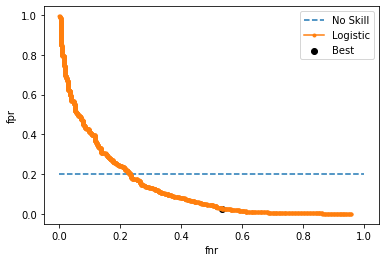

In [271]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import det_curve
from numpy import argmax
from numpy import argmin
from matplotlib import pyplot

# predict probabilities
yhat = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, fnr, thresholds = det_curve(y_test, yhat)

counter = Counter(y_test)
cost = fnr*counter[1]*150000 + (1-fnr)*counter[1]*100000 + fpr*counter[0]*50000


# locate the index of the largest f score
ix_cost = argmin(cost)
print('Best Threshold=%f' % (thresholds[ix_cost]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(fnr, fpr, marker='.', label='Logistic')
pyplot.scatter(fnr[ix_cost], fpr[ix_cost], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('fnr')
pyplot.ylabel('fpr')
pyplot.legend()
# show the plot
pyplot.show()

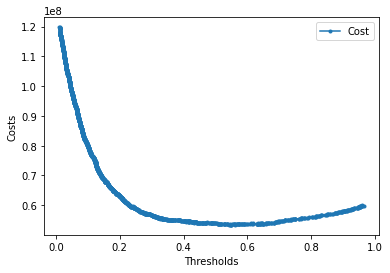

In [272]:
pyplot.plot(thresholds, cost, marker='.', label='Cost')
# axis labels
pyplot.xlabel('Thresholds')
pyplot.ylabel('Costs')
pyplot.legend()
# show the plot
pyplot.show()

0.5474882
Best Threshold=0.547488, F-Score=0.593
Precision=0.820961, recall=0.464


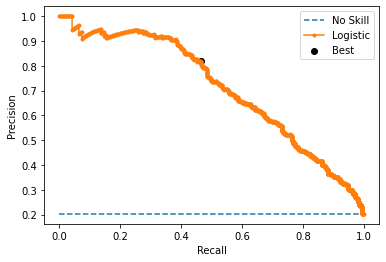

In [239]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
print(thresholds[ix_cost])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix_cost], fscore[ix_cost]))
print('Precision=%f, recall=%.3f' % (precision[ix_cost], recall[ix_cost]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix_cost], precision[ix_cost], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.321994, F-Score=0.639


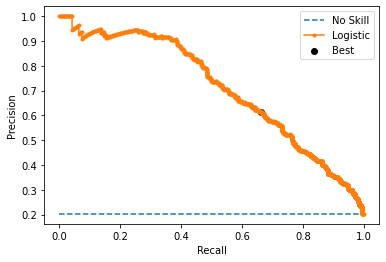

In [222]:
# predict probabilities
yhat = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [56]:
prob = xgb.predict_proba([641, 0, 1, 1,1,1,1, 1, 1, 55796.83])[:,1]
print(prob)

[0.14759769]


# Multiple Models

In [273]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

In [274]:
#Standard Scaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
X_train_s, X_test_s, y_train, y_test = train_test_split(X_standard, y, test_size = 0.2, random_state = 0)

In [275]:
models = {'Logistic Regression': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'Decision Tree': DecisionTreeClassifier(),
         'Random Forest': RandomForestClassifier(),
         'Gradient Boosting Classifier':GradientBoostingClassifier(),
         'Support Vector Machine': SVC(),
         'Stochastic Gradien Descent': SGDClassifier(),
         'Naive Bayes': GaussianNB(),
         'xgb Classifier': XGBClassifier()}

In [294]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

def my_custom_loss_func(y, y_pred, **kwargs):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  cost = fn*150000 + tp*100000 + fp*50000
  return cost

my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)


In [295]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring=my_scorer,
                                            cv=5
                                            ).mean()

    return model_scores

In [296]:
import warnings
warnings.filterwarnings("ignore")
model_scores = fit_score(models,X_train_s,X_test_s,y_train,y_test)

model_scores

{'Logistic Regression': -11800000.0,
 'KNN': -11460000.0,
 'Decision Tree': -12490000.0,
 'Random Forest': -10940000.0,
 'Gradient Boosting Classifier': -10890000.0,
 'Support Vector Machine': -10980000.0,
 'Stochastic Gradien Descent': -12430000.0,
 'Naive Bayes': -11460000.0,
 'xgb Classifier': -10870000.0}

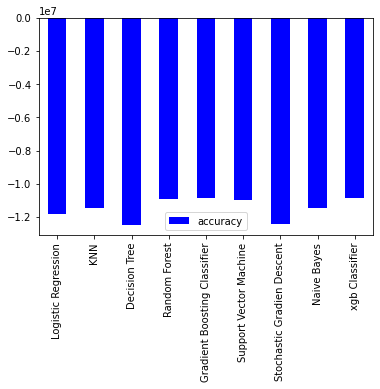

In [298]:
models = pd.DataFrame(model_scores, index=["accuracy"])
models.T.plot.bar(color="blue");

# Hyper parameter tuning


In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [172]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [179]:
print(Counter(y))

Counter({0: 7963, 1: 2037})


In [180]:
print(Counter(y_sm))

Counter({1: 7963, 0: 7963})


In [181]:
len(X)

10000

In [182]:
len(X_sm)

15926

In [183]:
params = {
        'min_child_weight': [3, 5, 7],
        'gamma': [0.7, 1, 1.3, 1.5],
        'subsample': [0.4, 0.6, 0.8, 1],
        'colsample_bytree': [0.4, 0.6, 0.8],
        'max_depth': [3, 5, 7]
        }

In [184]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=1)

In [185]:
folds = 3
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

In [186]:
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5864956ac0>,
                   estimator=XGBClassifier(learning_rate=0.02, n_estimators=600,
                                           nthread=1, silent=True),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.4, 0.6, 0.8],
                                        'gamma': [0.7, 1, 1.3, 1.5],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [3, 5, 7],
                                        'subsample': [0.4, 0.6, 0.8, 1]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [187]:
print(random_search.best_params_)

{'subsample': 0.6, 'min_child_weight': 3, 'max_depth': 7, 'gamma': 1.5, 'colsample_bytree': 0.8}


In [188]:
print(random_search.best_score_)

0.962860129083162


In [189]:
xgb = random_search.best_estimator_
xgb.fit(X_train, y_train)
predictions_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, predictions_xgb)
classification_xgb = (classification_report(y_test, predictions_xgb))
print(acc_xgb)
print(xgb.feature_importances_)
print(classification_xgb)

0.9136848713119899
[0.01766352 0.06335993 0.15201832 0.10494217 0.02080126 0.02408128
 0.20204245 0.04805056 0.34890765 0.01813285]
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1593
           1       0.95      0.87      0.91      1593

    accuracy                           0.91      3186
   macro avg       0.92      0.91      0.91      3186
weighted avg       0.92      0.91      0.91      3186

